

# Content

# Library

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

In [27]:
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [28]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)
library(RColorBrewer)
library(enrichplot)
library(clusterProfiler)
library(msigdbr)
library(gridExtra)

R[write to console]: 
Присоединяю пакет: ‘dplyr’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    filter, lag


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union




# Load data

In [40]:
df = pd.read_csv('clinvar_hpo_merged_data.csv', sep='\t')
df.head(2)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl
0,chr1,1013983,1028857,G,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608
1,chr1,1014143,183381,C,T,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608


In [42]:
# count MIMs associated with each gene

gene_mim = df[['GENEINFO', 'OMIM']].drop_duplicates()
gene_mim = gene_mim.groupby(['GENEINFO']).size().reset_index(name='MIMs_per_Gene')

,GENEINFO,MIMs_per_Gene
0,A2ML1,1
1,AAAS,1


In [43]:
print('N of genes:', gene_mim.drop_duplicates().shape[0])
print('N of genes with 2+ associated diseases:', gene_mim[gene_mim['MIMs_per_Gene'] > 1].drop_duplicates().shape[0])
print('N of genes with 2 associated diseases:', gene_mim[gene_mim['MIMs_per_Gene'] == 2].drop_duplicates().shape[0])

N of genes: 4211
N of genes with 2+ associated diseases: 1035
N of genes with 2 associated diseases: 670


In [44]:
# add number of associated diseases to initial df

df_m = df.merge(gene_mim, how='inner')
df_m.head(3)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl,MIMs_per_Gene
0,chr1,1013983,1028857,G,A,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1
1,chr1,1014143,183381,C,T,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1
2,chr1,1014316,161455,C,CG,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,Duplication,ISG15,OMIM:616126,Orphanet:319563,9636,AR,ENSG00000187608,1


In [45]:
df_m.to_csv('clinvar_grch38_plp_hpo_MIMcount.csv', sep='\t', index=False)

## Description of variants linkef to  2+ phenotypes 

In [53]:
df_m = pd.read_csv('clinvar_grch38_plp_hpo_MIMcount.csv', sep='\t')

In [55]:
# Count variants associated with 2+ phenotypes

var_multipheno = df_m[df_m['MIMs_per_Gene'] > 1]
var_multipheno = var_multipheno[['MIMs_per_Gene','GENEINFO', 'ID', 'OMIM']].drop_duplicates()

,MIMs_per_Gene,GENEINFO,ID,OMIM
45,3,B3GALT6,60484,OMIM:271640
46,3,B3GALT6,60488,OMIM:271640


In [56]:
var_multipheno_c = var_multipheno.groupby(['GENEINFO','ID']).size().reset_index(name='Variants_with_MultiMIMs')
var_multipheno_c.head(2)

,GENEINFO,ID,Variants_with_MultiMIMs
0,AARS1,8466,1
1,AARS1,190102,2


In [57]:
var_mulph_c = var_multipheno.merge(var_multipheno_c, on=['GENEINFO', 'ID'], how='inner')
var_mulph_c = var_mulph_c.drop_duplicates(subset=['GENEINFO', 'ID'])
var_mulph_c

,MIMs_per_Gene,GENEINFO,ID,OMIM,Variants_with_MultiMIMs
0,3,B3GALT6,60484,OMIM:271640,2
2,3,B3GALT6,60488,OMIM:271640,1
3,3,B3GALT6,60489,OMIM:271640,2
5,3,B3GALT6,60486,OMIM:271640,1
6,3,B3GALT6,522415,OMIM:271640,2
...,...,...,...,...,...
93208,2,RAB39B,156532,OMIM:311510,1
93209,2,RAB39B,1210217,OMIM:311510,1
93210,2,RAB39B,436462,OMIM:300271,1
93211,2,RAB39B,10542,OMIM:300271,1


In [58]:
var_mulph_c =  var_mulph_c.drop(columns=['OMIM'])
var_mulph_c= var_mulph_c.groupby(['MIMs_per_Gene','GENEINFO','Variants_with_MultiMIMs']).size().reset_index(name='N_variants')
var_mulph_c

,MIMs_per_Gene,GENEINFO,Variants_with_MultiMIMs,N_variants
0,2,ABCA1,1,20
1,2,ABCA1,2,1
2,2,ABCA12,1,24
3,2,ABCA12,2,4
4,2,ABCB11,1,39
...,...,...,...,...
2190,16,COL2A1,3,2
2191,16,COL2A1,5,1
2192,16,COL2A1,6,1
2193,16,COL2A1,13,3


In [59]:
var_mulph_c['Percent'] = 100 * var_mulph_c['N_variants'] / var_mulph_c.groupby('GENEINFO')['N_variants'].transform('sum')
var_mulph_c

,MIMs_per_Gene,GENEINFO,Variants_with_MultiMIMs,N_variants,Percent
0,2,ABCA1,1,20,95.238095
1,2,ABCA1,2,1,4.761905
2,2,ABCA12,1,24,85.714286
3,2,ABCA12,2,4,14.285714
4,2,ABCB11,1,39,78.000000
...,...,...,...,...,...
2190,16,COL2A1,3,2,0.917431
2191,16,COL2A1,5,1,0.458716
2192,16,COL2A1,6,1,0.458716
2193,16,COL2A1,13,3,1.376147


In [60]:
var_mulph_c.to_csv('SumVarPheno.csv', sep='\t', index=False)

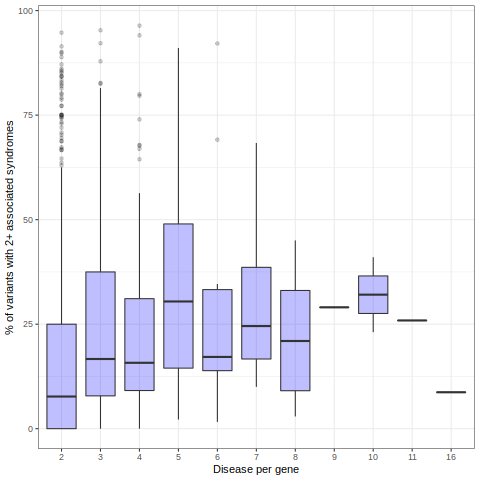

In [63]:
%%R -i var_mulph_c

var_mulph_pl <- var_mulph_c[var_mulph_c$Variants_with_MultiMIMs == 1, ]

ggplot(var_mulph_pl, aes(x=as.factor(MIMs_per_Gene), y=100-Percent)) +
geom_boxplot(fill='blue', alpha=0.25) + xlab('Disease per gene') +
ylab('% of variants with 2+ associated syndromes') + 
theme_set(theme_gray(base_family = "DejaVu")) +
theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + theme_bw()

### Review Status of variants associated with 2 MIMs  (based on ClinVar data)

In [130]:
var_multipheno_c

,GENEINFO,ID,Variants_with_MultiMIMs
0,AARS1,8466,1
1,AARS1,190102,2
2,AARS1,549673,1
3,AARS1,549676,1
4,AARS1,1164091,1
...,...,...,...
69514,ZNF408,931150,1
69515,ZSWIM6,155772,1
69516,ZSWIM6,431797,1
69517,ZSWIM7,1013608,2


In [144]:
df_m1 = df_m.merge(var_multipheno_c, on='ID', how='left')
df_m1 = df_m1[df_m1['MIMs_per_Gene'] > 1]
df_m1.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AF_EXAC,CLNREVSTAT,CLNSIG,CLNVC,GENEINFO_x,OMIM,ORPHA,ncbi_gene_id,Inheritance,Ensembl,MIMs_per_Gene,GENEINFO_y,Variants_with_MultiMIMs
45,chr1,1232279,60484,A,G,-10.0,PASS,NaN,"criteria_provided,_multiple_submitters,_no_con...",Pathogenic,single_nucleotide_variant,B3GALT6,OMIM:271640,Orphanet:93359,126792,AR,ENSG00000176022,3,B3GALT6,2.0
46,chr1,1232471,60488,A,G,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,B3GALT6,OMIM:271640,Orphanet:93359,126792,AR,ENSG00000176022,3,B3GALT6,1.0
47,chr1,1232478,60489,C,T,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,B3GALT6,OMIM:271640,Orphanet:93359,126792,AR,ENSG00000176022,3,B3GALT6,2.0
48,chr1,1232744,60486,G,A,-10.0,PASS,NaN,no_assertion_criteria_provided,Pathogenic,single_nucleotide_variant,B3GALT6,OMIM:271640,Orphanet:93359,126792,AR,ENSG00000176022,3,B3GALT6,1.0
49,chr1,1232834,522415,T,C,-10.0,PASS,NaN,"criteria_provided,_single_submitter",Pathogenic,single_nucleotide_variant,B3GALT6,OMIM:271640,Orphanet:93359,126792,AR,ENSG00000176022,3,B3GALT6,2.0


In [146]:
df_m1.to_csv('/interm/Variants_with_MultiMims.csv', sep='\t', index=False)

In [132]:
df_m1 = df_m1[['MIMs_per_Gene', 'CLNREVSTAT', 'Variants_with_MultiMIMs']]
df_m1.head()

,MIMs_per_Gene,CLNREVSTAT,Variants_with_MultiMIMs
45,3,"criteria_provided,_multiple_submitters,_no_con...",2.0
46,3,no_assertion_criteria_provided,1.0
47,3,"criteria_provided,_single_submitter",2.0
48,3,no_assertion_criteria_provided,1.0
49,3,"criteria_provided,_single_submitter",2.0


In [ ]:
df_m1 = df_m1[['MIMs_per_Gene', 'CLNREVSTAT', 'Variants_with_MultiMIMs']]
df_m1_2ph = df_m1[df_m1['MIMs_per_Gene'] == 2]
df_m1_2ph.head()

In [ ]:
%%R -i df_m1_2ph
df_m1_2ph <- df_m1_2ph %>%
    mutate(CLNREVSTAT = recode(CLNREVSTAT, "reviewed_by_expert_panel" = 'expert_panel', "practice_guideline" = 'guideline', 
                               "no_assertion_criteria_provided" =  'no_criteria', 
                              "criteria_provided,_single_submitter" = 'single_subm', 
                              "criteria_provided,_multiple_submitters,_no_conflicts" = 'multi_subm'))

In [ ]:
%%R

df_m1_2ph_stat <- na.omit(df_m1_2ph)%>%
  group_by(Variants_with_MultiMIMs, CLNREVSTAT) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))

df_m1_2ph_stat

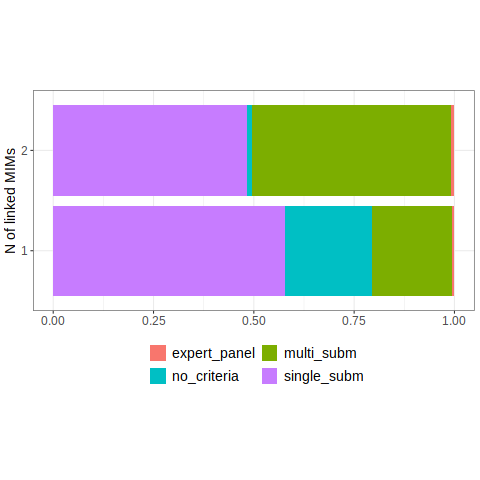

In [141]:
%%R

# stacked barchat
df_m1_bar <- ggplot(df_m1_2ph_stat, aes(y=prop, x=as.factor(Variants_with_MultiMIMs),
                               fill=factor(CLNREVSTAT))) +
    geom_bar(position="stack", stat="identity")+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + 
    xlab('N of linked MIMs') +  
    ylab(NULL)

df_m1_bar <- df_m1_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom")#+ scale_fill_brewer(palette='RdBu')
df_m1_bar <- df_m1_bar + theme(aspect.ratio = 1/2)  + coord_flip()
df_m1_bar

# Analysis of Tissue Expression  of GMDs

In [ ]:
import hail as hl
hl.init()

In [ ]:
! gsutil cp -r gs://gcp-public-data--gnomad/papers/2019-tx-annotation/data/GRCH38/GTEx.V8.tx_medians.021620.ht ./

In [ ]:
gtex = hl.read_table('GTEx.V8.tx_medians.021620.ht')

In [ ]:
df_gtex = gtex.to_pandas()

In [ ]:
df_gtex.head()

In [ ]:
df_gtex_m = pd.concat([df_gtex['agg_expression'].apply(pd.Series), df_gtex['transcript_id'], df_gtex['gene_id']], axis = 1)

In [ ]:
df_gtex_m.columns = ["ADPSBQ", "ADPVSC","ADRNLG", "ARTAORT", "ARTCRN","ARTTBL","BLDDER","BRNAMY","BRNACC","BRNCDT","BRNCHB","BRNCHA","BRNCTXA","BRNCTXB","BRNHPP","BRNHPT","BRNNCC", "BRNPTM","BRNSPC","BRNSNG","BREAST","LCL","FIBRBLS","CVXECT","CVSEND","CLNSGM", "CLNTRN","ESPGEJ","ESPMCS","ESPMSL","FLLPNT","HRTAA","HRTLV","KDNCTX","KDNMDL","LIVER","LUNG","SLVRYG","MSCLSK","NERVET","OVARY","PNCREAS","PTTARY","PRSTTE","SKINNS","SKINS","SNTTRM","SPLEEN","STMACH","TESTIS","THYROID","UTERUS","VAGINA","WHLBLD", "transcript_id", "gene_id"]

In [ ]:
df_gtex.to_csv('GTEx.V8.tx_medians.021620.csv', sep='\t', index=False)

In [ ]:
tx_medians = pd.read_csv('GTEx.V8.tx_medians.021620.csv', sep='\t')
print(tx_medians.shape)
print(tx_medians.head())

In [ ]:
cols = tx_medians.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
tx_medians = tx_medians[cols]
tx_medians.head()

In [ ]:
gene_mim_info = df_m[['Ensembl', 'MIMs_per_Gene']].drop_duplicates()
gene_mim_info.shape

In [ ]:
tx_medians = pd.merge(gene_mim_info, tx_medians, how='inner', left_on='Ensembl', right_on='gene_id')
print(tx_medians.shape)
print(tx_medians.head(3))

In [ ]:
tx_medians = tx_medians.drop(columns=['Ensembl'])

In [ ]:
cols = tx_medians.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
tx_medians = tx_medians[cols]
tx_medians.head()

In [ ]:
def gene_class(df):
    if df['MIMs_per_Gene'] == 1:
        return 'GSD'
    else:
        return 'GMD'

In [ ]:
tx_medians['GeneClass'] = tx_medians.apply(gene_class, axis = 1)
cols = tx_medians.columns.tolist()
cols = cols[-1:] + cols[:-1]
tx_medians = tx_medians[cols]
tx_medians.head()

In [ ]:
# check if any value in a row is bigger than 5
def check_row(row):
    row_to_filter = row[4:]
    return any(row_to_filter > 5)

In [ ]:
# Apply the function to each row and filter the DataFrame
tx_medians_flt = tx_medians[tx_medians.apply(check_row, axis=1)]


print(tx_medians_flt.shape)
print(tx_medians.shape)

tx_medians_flt.head()

In [ ]:
gene_tx_flt = tx_medians_flt[['gene_id', 'transcript_id']]
tx_medians_flt_per_gene= gene_tx_flt.groupby(['gene_id']).size().reset_index(name = 'tx_per_gene')
tx_medians_flt_per_gene.head()

In [ ]:
tx_medians_flt_per_gene = tx_medians_flt_per_gene.merge(tx_medians_flt, on='gene_id')

In [ ]:
tx_number = tx_medians_flt_per_gene[['GeneClass', 'tx_per_gene']]

In [ ]:
%%R -i tx_number

tx_number <- as.data.frame(tx_number)
head(tx_number)

In [ ]:
%%R

wilcox.test(tx_number$tx_per_gene[tx_number$GeneClass == 'GSD'], tx_number$tx_per_gene[tx_number$GeneClass == 'GMD'], alternative="less")

In [ ]:
%%R 

ggplot(tx_number, aes(x=tx_per_gene, fill=GeneClass)) + 
geom_histogram(aes(y=..density..),binwidth=1) + geom_density(alpha=.2) + facet_wrap(~GeneClass,nrow=2)

In [ ]:
%%R

write.csv(tx_number, 'tx_number.csv', quote=FALSE)

# Constraint metrics of GMDs

source: https://gnomad.broadinstitute.org/

In [66]:
! wget https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
    
! gunzip -c  gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz  | cut -f1,21,30,36 > ./data/gnomad.v2.1.1.pli_loeuf.txt

--2023-09-25 10:18:18--  https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
Распознаётся storage.googleapis.com (storage.googleapis.com)… 64.233.161.207, 173.194.221.207, 64.233.165.207, ...
Подключение к storage.googleapis.com (storage.googleapis.com)|64.233.161.207|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 4609488 (4,4M) [application/octet-stream]
Сохранение в: «gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz»

gnomad.v2.1.1.lof_m 100%[===================>]   4,40M  4,34MB/s    за 1,0s    

2023-09-25 10:18:19 (4,34 MB/s) - «gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz» сохранён [4609488/4609488]



In [67]:
# pLI & loeuf data from gnomAD

gnomad = pd.read_csv('gnomad.v2.1.1.pli_loeuf.txt', sep='\t')
gnomad.head(2)

,gene,pLI,oe_lof_upper,oe_lof_upper_bin
0,MED13,1.0,0.030,0.0
1,NIPBL,1.0,0.032,0.0


In [68]:
# select genes that are in df (merged data)

genes = df_m[['GENEINFO']].drop_duplicates()
genes.shape

(4211, 1)

In [86]:
gnomad_flt = pd.merge(gnomad, genes, left_on=['gene'], right_on=['GENEINFO'], how='inner')

print(gnomad_flt.shape)
print(gnomad_flt.head())

(4004, 5)
    gene  pLI  oe_lof_upper  oe_lof_upper_bin GENEINFO
0  MED13  1.0         0.030               0.0    MED13
1  NIPBL  1.0         0.032               0.0    NIPBL
2   SMC3  1.0         0.037               0.0     SMC3
3  CNOT1  1.0         0.038               0.0    CNOT1
4   TAF1  1.0         0.043               0.0     TAF1


In [87]:
# select genes with 2+ pheno (merged data)

genesMulPh = df_m[df_m['MIMs_per_Gene'] > 1]
genesMulPh = genesMulPh[['GENEINFO']].drop_duplicates()

### pLI 

In [88]:
# select pLI

gn_pLI = gnomad_flt[['GENEINFO', 'pLI']]

In [89]:
# mark genes with 1 and 2+ associated diseases

pLI = pd.merge(gn_pLI, genesMulPh, on=['GENEINFO'], how='left', indicator='Multiple_phenotypes')
pLI['Multiple_phenotypes'] = np.where(pLI.Multiple_phenotypes == 'both', True, False)
pLI.shape
pLI.head()

,GENEINFO,pLI,Multiple_phenotypes
0,MED13,1.0,False
1,NIPBL,1.0,False
2,SMC3,1.0,False
3,CNOT1,1.0,False
4,TAF1,1.0,True


In [90]:
pLI.to_csv('pLI_dfgenes.csv', sep='\t', index=False)

In [91]:
pLI = pd.read_csv('pLI_dfgenes.csv', sep='\t')

In [92]:
%%R -i pLI

pLI$pLI <- as.character(pLI$pLI)
pLI$pLI <- as.numeric(pLI$pLI)

print(nrow(pLI[pLI$Multiple_phenotypes == 'TRUE', ]))
print(nrow(pLI[pLI$Multiple_phenotypes == 'FALSE', ]))

[1] 1002
[1] 3002


In [93]:
%%R

wilcox.test(pLI$pLI[pLI$Multiple_phenotypes == 'FALSE'], pLI$pLI[pLI$Multiple_phenotypes == 'TRUE'], alternative="less")


	Wilcoxon rank sum test with continuity correction

data:  pLI$pLI[pLI$Multiple_phenotypes == "FALSE"] and pLI$pLI[pLI$Multiple_phenotypes == "TRUE"]
W = 1469023, p-value = 0.1451
alternative hypothesis: true location shift is less than 0



In [117]:
%%R

# classify pLI value 

pLI <- pLI %>% 
  mutate(class = case_when(
    pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
    pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
    pLI > 0.1 & pLI < 0.9 ~ 'intermediate tolerance'))

# count
stat_pli <- na.omit(pLI)%>%
  group_by(Multiple_phenotypes, class) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))


stat_pli
write.csv(stat_pli, 'pli_dfgenes.csv', sep='\t', quote=FALSE)

`summarise()` has grouped output by 'Multiple_phenotypes'. You can override
using the `.groups` argument.


In [95]:
%%R

test <- as.data.frame(stat_pli)
test <- test[test$class != "intermediate tolerance", ]
as.data.frame(test)

  Multiple_phenotypes                       class count      prop
2               FALSE pLOF intolerant (pLI >=0.9)   698 0.2327442
3               FALSE   pLOF tolerant (pLI <=0.1)  1865 0.6218740
5                TRUE pLOF intolerant (pLI >=0.9)   287 0.2864271
6                TRUE   pLOF tolerant (pLI <=0.1)   570 0.5688623


In [96]:
%%R

dat <- data.frame(pli=c(rep("Tol", 2435),rep("InT", 985)), MPh=c(rep('FALSE', 1865), rep('TRUE',570 ), rep('FALSE', 698), rep('TRUE', 287)))

In [97]:
%%R
table(dat)

     MPh
pli   FALSE TRUE
  InT   698  287
  Tol  1865  570


In [98]:
%%R 
chisq.test(dat$MPh, dat$pli)


	Pearson's Chi-squared test with Yates' continuity correction

data:  dat$MPh and dat$pli
X-squared = 11.952, df = 1, p-value = 0.000546



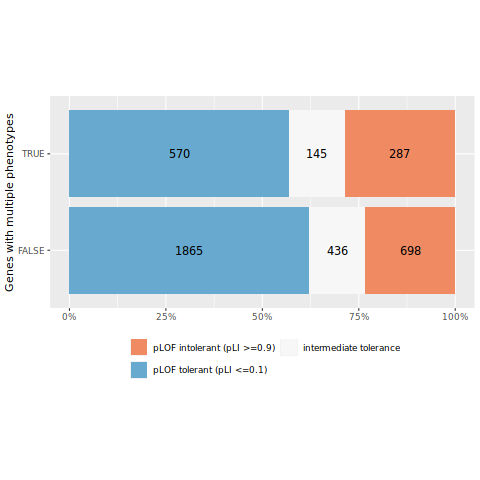

In [99]:
%%R

pli_bar <- ggplot(na.omit(stat_pli), aes(y=prop, x=Multiple_phenotypes, label=count,
                               fill=factor(class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)", 'NA')))) +
    geom_bar(position="stack", stat="identity")+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + 
    xlab('Genes with multiple phenotypes') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + theme_set(theme_gray(base_family = "DejaVu")) + geom_text(size = 4, position = position_stack(vjust = 0.5), family='DejaVu')

pli_bar <- pli_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom") + scale_fill_brewer(palette = "RdBu")
pli_bar <- pli_bar + theme(aspect.ratio = 1/2)  + coord_flip() 
pli_bar


### LOEUF 

In [101]:
# select loeuf

gn_loeuf = gnomad_flt[['GENEINFO', 'oe_lof_upper', 'oe_lof_upper_bin']]

In [102]:
loeuf = pd.merge(gn_loeuf, genesMulPh, on=['GENEINFO'], how='left', indicator='Multiple_phenotypes')
loeuf['Multiple_phenotypes'] = np.where(loeuf.Multiple_phenotypes == 'both', True, False)
loeuf.shape

(4004, 4)

In [121]:
loeuf.to_csv('LOEUF_dfgenes.csv', sep='\t', index=False)

In [122]:
loeuf = pd.read_csv('LOEUF_dfgenes.csv', sep='\t')

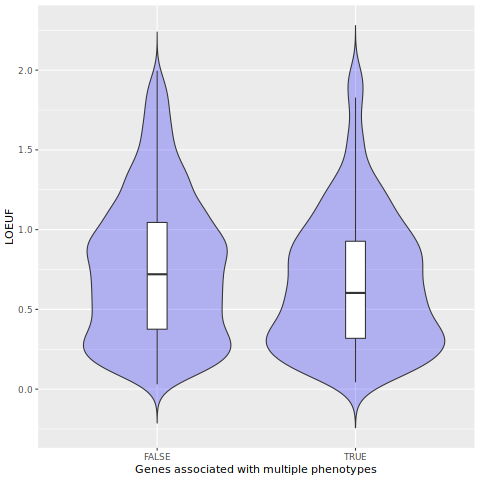

In [123]:
%%R -i loeuf

loeuf_violin <- ggplot(na.omit(loeuf), aes(x=Multiple_phenotypes, y=oe_lof_upper)) + 
                geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + 
                theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + 
                xlab('Genes associated with multiple phenotypes') + ylab('LOEUF') + theme_set(theme_gray(base_family = "DejaVu"))

loeuf_violin <- loeuf_violin + geom_boxplot(width=0.1, outlier.shape = NA)

loeuf_violin

In [124]:
%%R

wilcox.test(loeuf$oe_lof_upper[loeuf$Multiple_phenotypes == 'FALSE'],
            loeuf$oe_lof_upper[loeuf$Multiple_phenotypes == 'TRUE'], alternative='greater')


	Wilcoxon rank sum test with continuity correction

data:  loeuf$oe_lof_upper[loeuf$Multiple_phenotypes == "FALSE"] and loeuf$oe_lof_upper[loeuf$Multiple_phenotypes == "TRUE"]
W = 1682081, p-value = 7.027e-09
alternative hypothesis: true location shift is greater than 0



In [127]:
%%R

# count
loeuf_dec <- na.omit(loeuf)%>%
  group_by(Multiple_phenotypes, oe_lof_upper_bin) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))

head(loeuf_dec)
write.csv(loeuf_dec, 'loeuf_dec.csv', sep='\t', quote=FALSE)

`summarise()` has grouped output by 'Multiple_phenotypes'. You can override
using the `.groups` argument.


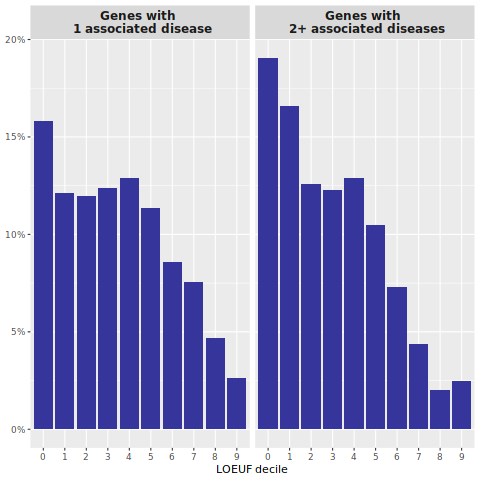

In [112]:
%%R

loeuf_dec_pl <- ggplot(na.omit(loeuf_dec), aes(x=as.factor(oe_lof_upper_bin), y=prop)) + geom_bar(stat='identity')+
 geom_bar(position="stack", stat="identity", fill='blue', alpha=0.4)+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=10)) + 
    xlab('LOEUF decile') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + theme_set(theme_gray(base_family = "DejaVu"))

genes.labs <- c("Genes with \n 1 associated disease", "Genes with \n 2+ associated diseases")
names(genes.labs) <- c("FALSE", "TRUE")
                      
loeuf_dec_pl <- loeuf_dec_pl + facet_grid(. ~ Multiple_phenotypes, labeller = labeller(Multiple_phenotypes = genes.labs)) + 
                theme(strip.text.x = element_text(size = 12, face = "bold")) 

loeuf_dec_pl

In [113]:
%%R

wilcox.test(loeuf$oe_lof_upper_bin[loeuf$Multiple_phenotypes == 'FALSE'], loeuf$oe_lof_upper_bin[loeuf$Multiple_phenotypes == 'TRUE'])


	Wilcoxon rank sum test with continuity correction

data:  loeuf$oe_lof_upper_bin[loeuf$Multiple_phenotypes == "FALSE"] and loeuf$oe_lof_upper_bin[loeuf$Multiple_phenotypes == "TRUE"]
W = 1676811, p-value = 2.886e-08
alternative hypothesis: true location shift is not equal to 0



## HPO Upper Terms linked to GMDs

In [ ]:
# select genes  with 2 associated syndromes

genes2pheno_to_mim = df_m[df_m['MIMs_per_Gene'] == 2]
genes2pheno_to_mim = genes2pheno_to_mim[['GENEINFO', 'OMIM']].drop_duplicates()
genes2pheno_to_mim

In [ ]:
# list of genes - MIM associations for genes with 2 diseases 

genes2pheno_to_mim.to_csv('G2Ph_MIM.csv', sep='\t', index=False)

! sed -i 1d G2Ph_MIM.csv

In [ ]:
# list of genes with 2 associated diseases

genes2pheno_to_mim['GENEINFO'].drop_duplicates().to_csv('G2Ph_genes.txt', sep='\t', index=False)

! sed -i 1d G2Ph_genes.txt

In [ ]:
# run script for similarity scores estimation

! bash /script/g2ph_simscore.sh

In [ ]:
gsd_terms = pd.read_csv('GSD_nterms.csv', sep=',')
gsd_terms.head()

gsd_terms['N_MIMs'] = "GSD"

In [ ]:
gmd_terms = pd.read_csv('GMD_nterms.csv', sep=',')
gmd_terms.head()

gmd_terms['N_MIMs'] = "GMD"

In [ ]:
top_terms = pd.concat([gsd_terms, gmd_terms], axis=0)

In [ ]:
%%R -i top_terms
top_terms <- as.data.frame(top_terms)

In [ ]:
%%R

wilcox.test(top_terms$N_upperterms[top_terms$N_MIMs == 'GSD'], top_terms$N_upperterms[top_terms$N_MIMs == 'GMD'] )

In [ ]:
%%R

ggplot(top_terms, aes(x=N_MIMs, y=N_upperterms)) + geom_boxplot()

# Enrichment Analysis

### collect genes with 2+ phenotypes 

In [115]:
# List of genes with multiple associated phenotypes for Enrichment Analysis (merged data)

genesmultipheno_for_EA = df_m[df_m['MIMs_per_Gene'] > 1]
genesmultipheno_for_EA = genesmultipheno_for_EA[['GENEINFO', 'Ensembl']].drop_duplicates()
genesmultipheno_for_EA.to_csv('GeneMultiPheno_ensg_for_EA.csv', sep='\t', index=False)

In [116]:
%%R -i genesmultipheno_for_EA

mgene <- unique(genesmultipheno_for_EA$Ensembl)
length(mgene)

[1] 1035


### universe = genes from custom dataframe

In [119]:
# merged data

universe = df_m[['Ensembl']].drop_duplicates()
universe.shape[0]

4210

In [120]:
universe.to_csv('df_genelist.txt', index=False)

### 9.1. C2.Canonical Pathways collection 

In [60]:
%%R -i universe

### load collection
C2.CP <- as.data.frame(msigdbr(species = "Homo sapiens", 
                               category = "C2",
                               subcategory = "CP:BIOCARTA")) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:KEGG"))) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:PID"))) %>% 
  bind_rows(as.data.frame(msigdbr(species = "Homo sapiens", 
                                  category = "C2",
                                  subcategory = "CP:REACTOME")))


## subset collection based on OMIM genes for enrichment

C2.CP <- C2.CP %>% 
  dplyr::select(gs_name, ensembl_gene)

C2CP_t2g <-C2.CP %>%
  filter(ensembl_gene %in% universe$Ensembl)

print(nrow(C2.CP))
print(nrow(C2CP_t2g))

[1] 130371
[1] 33699


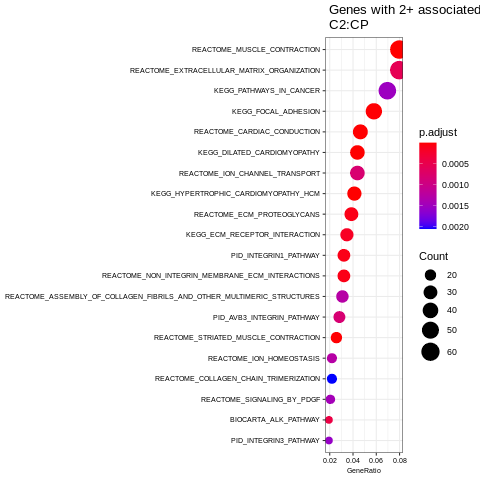

In [61]:
%%R

mres_C2CP <- enricher(mgene, TERM2GENE = C2CP_t2g)

dotplot(mres_C2CP, showCategory = 20,font.size = 7)+ ggtitle(' Genes with 2+ associated diseases \n C2:СР')

### 9.2 C5.HPO collection

In [62]:
%%R -i universe

C5.HPO <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = "HPO")

HPO <- C5.HPO %>% 
  dplyr::select(gs_name, ensembl_gene)

C5HPO_t2g <-HPO %>%
  filter(ensembl_gene %in% universe$Ensembl)

print(nrow(HPO))
print(nrow(C5HPO_t2g))

[1] 464649
[1] 337013


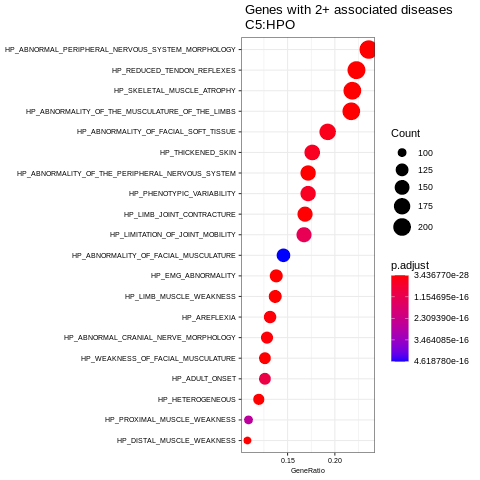

In [63]:
%%R

mres_C5 <- enricher(mgene, TERM2GENE = C5HPO_t2g)

dotplot(mres_C5, showCategory = 20,font.size = 7) + ggtitle(' Genes with 2+ associated diseases \n C5:HPO')
